### RatR Day2 SD recording info

In [1]:
import numpy as np
import subjects

sess = subjects.sd.ratRday2[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.xml 
# channels: 128
sampling rate: 30000
lfp Srate (downsampled): 1250



## Set probe configuration
Lets create probe configuration for a 128-channel probe

In [ ]:
%matplotlib widget
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(8):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=16.5,
        ypitch=15,
        y_shift_per_column=[0,-7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save()
plot_probe(prbgrp)

## Create epochs for your experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [ ]:
sess.paradigm.to_dataframe()

In [3]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 7302, 10685,10685,28685,43157],
        "stop": [7288, 10683, 43156,28685,43156,47043],
        "label": ["pre", "maze", "post",'sd','rs','re-maze'],
    }
)

paradigm= Epoch(epochs=epochs)
paradigm.save(sess.filePrefix.with_suffix('.paradigm.npy'))

/data/Clustering/sessions/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.paradigm.npy saved


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Importing spiketrains from Phy

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatR/Day2SD/spykcirc/phy"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=sess.neurons.neuron_type,
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

# BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
# plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Position
- concatenated .dat file did not have any deleted timepoints

## Import position from optitrack

In [4]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder,scale_factor=1)

/data/Clustering/sessions/RatR/Day2SD/position/Take 2021-05-23 11.13.55 AM.csv


In [ ]:
opti_data.datetime_starts

## Align position with .dat file

In [5]:
import pandas as pd
from datetime import datetime

# ------- maze align corection ---------
t_error = [0,0.217,0,0]  # estimated using theta/speed

#---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta( t_error[i],unit='sec')
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    # print(duration.total_seconds()*tracking_sRate)
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
        # freq='16.66ms',
        closed='left'
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

x,y,z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z,x,y))

position = Position(traces=traces,t_start=0,sampling_rate=opti_data.sampling_rate)
position.save(sess.filePrefix.with_suffix('.position.npy'))

/tmp/ipykernel_2731728/1443372518.py:17: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  trange = pd.date_range(


/data/Clustering/sessions/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.position.npy saved


## Linearize position

/data/Clustering/sessions/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.maze.linear saved


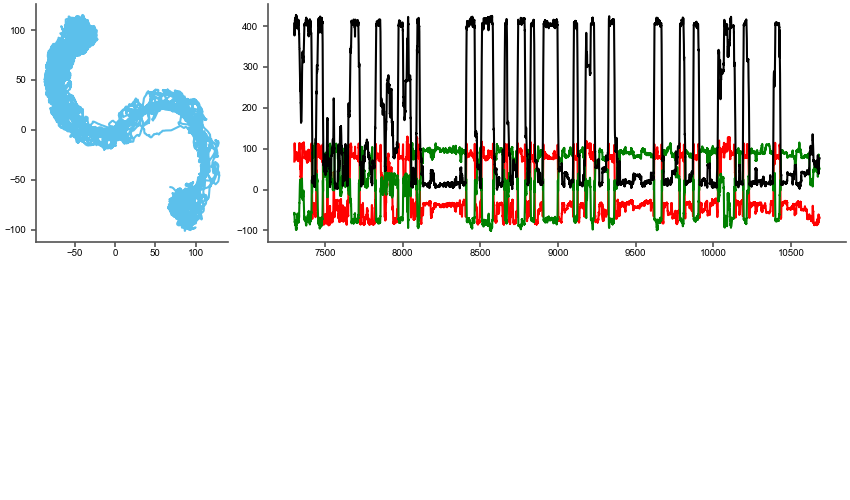

In [2]:
from neuropy.utils import position_util
from neuropy import plotting

maze = sess.paradigm['maze'].flatten()
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)
linear_pos.save(sess.filePrefix.with_suffix('.maze.linear'))


fig = plotting.Fig(grid=(2,4),size=(8.5,5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x,maze_pos.y)

ax = fig.subplot(fig.gs[0,1:])
ax.plot(maze_pos.time,maze_pos.x,'r')
ax.plot(maze_pos.time,maze_pos.y,'g')
ax.plot(linear_pos.time,linear_pos.x,'k')